# Create Experimental Data Set

I'd like to create experimental data set based on home characteristics and sales, where the theoretical model would be trying to predict eventual sale price.

I'll have:
- a continuous variable (square feet of living space)
- a categorical variable with a large number of categories (zip code, 50)
- a categorical variable with a small number of variables (condition, 5)
- a variable I'll create to add some randomness to the price, probably a "day of the week" where we'll pretend that the day of the week when the house was listed affects its price.

I'll be able to remove one each of the OHE categorical variables and model with all variables and get a very good model.

I can also not include the "day of the week" random variable to more closely approximate trying to model without data that explains all the variation.

To start with, square feet will have a normal distribution.

Zip codes will be created in random unequal sizes, but will be assigned a price multiplier based on a normal distribution. I'll make sure that the first zip code alpha-numerically is one with a smaller than average number of houses and larger than average or smaller than average price multipliers, so I can simulate dropping an outlier versus an average category.

The condition category will be poor, below average, average, above average, and excellent. It will be assigned randomly, and will be roughly normal but we will have mostly averages, a few below averages, and more above and excellent than below.




In [441]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [442]:
def assign_cats(df_groups, df_records, ratio_map={}, seed=5):
    """Assigns group labels and multipliers to records to create an
    experimental data set.
    
    Returns the original mergeto dataframe with the group labels and 
    multipliers assigned in new columns.
    
    Keyword arguments:
    
    df_groups: a dataframe consisting of a group of categorical labels
    and corresponding multiplier column representing the weight of effect for
    that group. Group label should be in column 1 (index 0), and multiplier in 
    column 2 (index 1).
    
    df_records: a dataframe representing records to which the groups will be
    assigned. Records df should have more rows than groups, where groups will
    be assigned to batches of records.
    
    ratio_map: default, none. A dict consisting of keys = labels and 
    values = proportion of records to be assigned that label. Proportions
    should sum to 1. 
    
    - If a ratio map is passed, this will be used to determine
    group sizes instead of making them roughly equal and assigning to labels
    randomly.
    
    - If no ratio map passed, determines roughly even but varied group sizes 
    based on number of groups and number of total records, and assigns the 
    group labels and multipliers to the records randomly.
    
    seed: default 5. Integer representing random seed for reproducability.
    """
    np.random.seed(seed)
    
    record_ct = len(df_records)
    group_ct = len(df_groups)
    groups_sizes = []
    group_index = []
    
    # apply group sizes using ratio map, if passed
    if len(ratio_map.items()) > 0:
        
        for i, v in enumerate(ratio_map.values()):
            if i == (group_ct - 1):
                remaining = record_ct - np.sum(groups_sizes)
                groups_sizes.append(np.around(remaining, decimals=0))
            else:
                groups_sizes.append(np.around((record_ct * v), decimals=0))
        
    else:
        # determine the group size if we were to divide evenly
        split = np.around((record_ct / group_ct), decimals=0)

        # loop for each group and assign it a randomly altered size
        while len(groups_sizes) < group_ct:

            # if last 4 groups, spread evenly between them
            if len(groups_sizes) == (group_ct - 4):
                remaining = record_ct - np.sum(groups_sizes)
                last4 = np.around((remaining / 4), decimals=0)
                for i in range(0, 3):
                    groups_sizes.append(last4)
                groups_sizes.append(record_ct - np.sum(groups_sizes))
            else:
                # generate a random int between size and 0 to alter the size
                alterby = np.random.randint(low=0, high=split, dtype=int)

                # add alter variable to half the size and append to list
                groups_sizes.append((np.around((split / 2), decimals=0)) + alterby)
    
    # loop through groups and create appropriate number of copies for
    # each group size
    for i, size in enumerate(groups_sizes):
        for j in range(0, int(size)):
            group_index.append(list(df_groups.iloc[i].values))
            
    # shuffle group index to re-randomize it
    np.random.shuffle(group_index)
    
    group_records = pd.DataFrame(group_index, columns=df_groups.columns)
    
    # concatenate dfs
    new_df = pd.concat([df_records, group_records], axis=1)

    return new_df

In [443]:
def explore_data(to_explore, df, target, hist=True, box=True, plot_v_target=True,
                 summarize=True, norm_check=True):
    """Creates plots and summary information intended to be useful in preparing
    for linear regerssion modeling. Prints plots of distributions, a scatter
    plot of each predictor column against a target, and outputs a dataframe of
    metadata including results of a normality check and correlation coefficient.
    
    Keyword arguments:
    
    to_explore: list of column names to explore
    
    df: Dataframe containing the columns in to_explore, as well as the target
        column
    
    target: string of the column name to use as the target, or dependent variable
    
    hist: True or False (default True). Whether to include a histogram for each
    predictor column.
    
    box: True or False (default True). Whether to include a box plot for each
    predictor column.
    
    plot_v_target: True or False (default True). Whether to include a scatter 
    plot showing the predictor versus target
    
    summarize: True or False (default True). Whether to include a summary of
    the values in each predictor column. Data will be summarized using 
    df.describe() for variables deemed continuous, and df.sort_values()
    for variables deemed categorical. Classification of continuous versus
    categorical is best effort.
    
    norm_check: True or False (default True). Whether to perform a normality
    check using SciPy's stats omnibus normality test. Null hypothesis 
    is that the data comes from a normal distribution, so a value less than
    0.05 represents likely NOT normal data.
    """
    
    # Create some variables to dynamically handle including/excluding 
    # certain charts
    num_charts = 0
    if hist:
        num_charts += 1
    if box:
        num_charts += 1 
    if plot_v_target:
        num_charts += 1
        
    # check if input column is a list; if not, make it one. This allows for
    # a string to be passed if only one column is being summarized.
    if type(to_explore) == str:
        temp_list = [to_explore]
        to_explore = temp_list
    
    # column headers for metadata output df
    meta_list = [['col_name', 'corr_target', 'assumed_var_type', 'omnibus_k2',
                 'omnibus_pstat', 'is_normal', 'uniques', 'mean', 'median']]
    
    # loop through each column in the list to analyze
    for col in to_explore:
        
        header_line = '-'*75
        header_text = f'\nExploring column: {col}\n'
        print(header_line + header_text + header_line)
        
        # Determine if categorical or continuous
        # assume continuous to begin with
        var_type = 'continuous'
        data_type = df[col].dtype
        uniques = np.nan
        mean = np.nan
        median = np.nan
        num_uniques = len(df[col].unique())
        
        if df[col].dtype in ['int64', 'float64']:
            # number types need the most analysis because they could be
            # categorical even if they're numeric
            
            # using 100 as an arbitrary cutoff here, may need adjustment
            if num_uniques < 20:
                var_type = 'categorical'
                uniques = num_uniques
            else:
                mean = np.mean(df[col])
                median = np.median(df[col])
        elif df[col].dtype in ['object']:
            # Assuming column types have been fixed at this point,
            # so if a column is not numerical it must be categorical
            var_type = 'categorical'
            uniques = num_uniques
        elif df[col].dtype in ['datetime64']:
            var_type = 'date'
            
        # print summary based on data type
        if summarize:
            if var_type in ['continuous', 'date']:
                header_text = f'\ndf.describe() for continuous data: {col}\n'
                print(header_line + header_text + header_line)
                print(df[col].describe())
            else:
                header_text = f'\nValue Counts for categorical data: {col}\n'
                print(header_line + header_text + header_line)
                with pd.option_context('display.max_rows', 20):
                    print(df[col].value_counts())
        
        # creates scatter plots, histogram, and box plots for numerical data
        if data_type in ['int64', 'float64']:
            if num_charts > 0:

                fig, axes = plt.subplots(nrows=num_charts, ncols=1, 
                                         figsize=(8, num_charts * 5))
                if hist:
                    if num_charts > 1:
                        ax1 = axes[0]
                    else:
                        ax1 = axes

                    if box:
                        ax2 = axes[1]
                        if plot_v_target:
                            ax3 = axes[2]
                    elif plot_v_target:
                        ax3 = axes[1]
                elif box:
                    if num_charts > 1:
                        ax2 = axes[0]
                    else:
                        ax2 = axes

                    if plot_v_target:
                        ax3 = axes[1]

                elif plot_v_target:
                    ax3 = axes


                # add a little extra space for headers
                plt.subplots_adjust(hspace=0.3)

                # Histogram
                if hist:
                    sns.histplot(df[col], kde=True, ax=ax1)
                    ax1.set_title(f"Hist {col}")

                # Box plot
                if box:
                    sns.boxplot(x=df[col], ax=ax2)
                    ax2.set_title(f"Boxplot {col}")

                # Plot against target
                # create a series representing quartiles, to use as hue
                if plot_v_target:                
                    if var_type == 'continuous':
                        try:
                            quartile_labels=['q1', 'q2', 'q3', 'q4']
                            quartiles = pd.qcut(df[col], 4, 
                                                labels=quartile_labels, 
                                                duplicates='drop')
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3, 
                                            hue=quartiles)
                            ax3.legend(title=f'{col} quartiles')
                            
                        except:
                            sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    else:
                        sns.scatterplot(x=df[col], y=df[target], ax=ax3)
                    ax3.set_title(f"{col} versus {target}")
                    
                plt.show();
                
            # get pearson correlation coefficient between col and target
            corr = df[[col, target]].corr()

            # Test for normality using scipy omnibus normality test
            # null hypothesis is that the data comes from a normal distribution
            if norm_check:
                k2, p = stats.normaltest(df[col])
                if p < 0.05:
                    normal = False
                    print(f'\nData is NOT normal with p-statistic = {p}\n')
                else:
                    normal = True
                    print(f'\nData IS normal with p-statistic = {p}\n')

            # append metadata to list of lists
            meta_list.append([col, corr.iloc[0][1], var_type, k2, p, normal, 
                uniques, mean, median])
            
        # Create catplot for categorical data
        elif data_type in ['object', 'str']:
            # get variable to determine appropriate height based on number
            # of categories to be displayed
            h = len(df[col].value_counts())
            
            # Get list of categories sorted in alpha order
            order = df[col].unique()
            order.sort()
            
            fig, ax = plt.subplots(figsize=(8, (h*0.15)+4))
            sns.barplot(x=target, y=col, data=df, orient='h', 
                        order=order, ax=ax)
            ax.set_title(f"Average {target} per {col}");
            plt.show();
        
    df_meta = pd.DataFrame(data=meta_list[1:], columns=meta_list[0])
    return df_meta

## Sq Ft

In [444]:
# Generate sq ft

# Set random seed for reproducability
np.random.seed(5)
df = pd.DataFrame(((np.random.randn(20000)) + 4) * 700, columns=['sqft'])

print(df.head())
print(f"Mean sq ft: {np.mean(df)}")
print(f"Median sq ft: {np.median(df)}")

       sqft
0 3108.8592
1 2568.3909
2 4501.5398
3 2623.5355
4 2876.7269
Mean sq ft: sqft   2801.1306
dtype: float64
Median sq ft: 2803.5581213839223


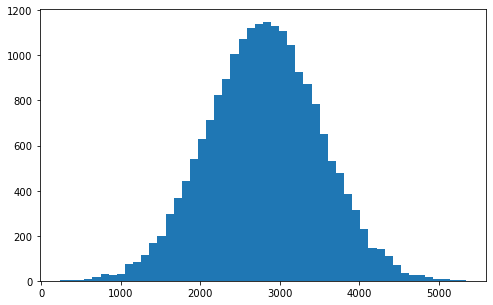

In [445]:
# Plot the sq ft values to confirm their distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['sqft'], bins=50);

## Zip Codes

In [446]:
# Next we'll generate a set of 70 fake zip codes

# Set random seed for reproducability
np.random.seed(5)

zips = np.round(np.random.randn(150),2)
zips = (np.unique(abs(zips)) * 100) + 30000
zips = np.unique(zips)[:70]
np.random.shuffle(zips)

print(zips[:5])
print(f"Unique zip codes: {len(np.unique(zips))}")

[30061. 30043. 30106. 30114. 30089.]
Unique zip codes: 70


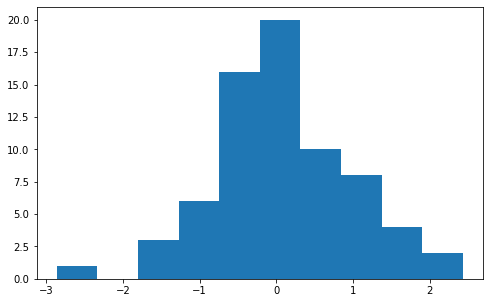

In [447]:
# And assign a random multiplier for price to each zip code.

# Set random seed for reproducability
np.random.seed(5)
zips_x = np.random.randn(70)

# check distribution for zipcode multipliers
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(zips_x);

In [448]:
# combine zipcodes with their multipliers
zips = np.concatenate((zips.reshape(len(zips), 1), 
                       zips_x.reshape(len(zips_x), 1)), axis=1)

# Sort zips so the first will have the lowest multiplier
zips.sort(axis=0)
print(zips[:5])
print(zips[-5:])

[[30000.       -2.86 ]
 [30001.       -1.665]
 [30002.       -1.511]
 [30005.       -1.311]
 [30006.       -1.193]]
[[30106.        1.562]
 [30114.        1.582]
 [30115.        1.857]
 [30116.        2.26 ]
 [30117.        2.431]]


In [449]:
# Turn array into a dataframe and convert zipcode to string
df_zips = pd.DataFrame(zips, columns=['zip','zip_multi'])

df_zips['zip'] = df_zips['zip'].astype(str, copy=False)
df_zips['zip'] = df_zips['zip'].map(lambda x: x[:5])

df_zips.head()

,zip,zip_multi
0,30000,-2.8597
1,30001,-1.6648
2,30002,-1.5112
3,30005,-1.3108
4,30006,-1.1928


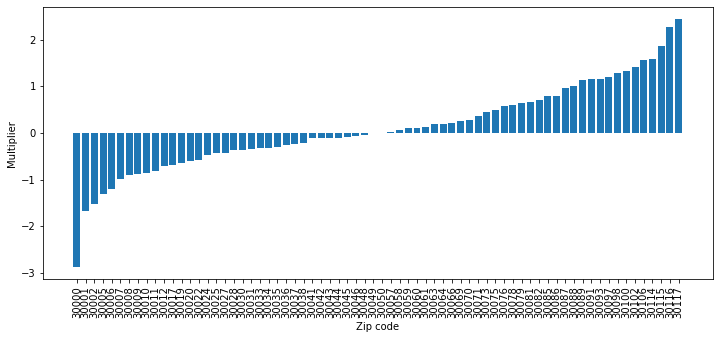

In [450]:
# show distribution of multipliers across zips
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x=df_zips['zip'], height=df_zips['zip_multi'])
ax.set_xlabel('Zip code')

ax.tick_params(axis='x', which='major', rotation=90)

ax.set_ylabel('Multiplier');

When we naturally drop the first category of zips, it will represent a zip code with a multiplier on the extreme low end, which will not be very representative of the population average. That's what I want to simulate in this experiment.

I'm going to assign zip codes randomly to groups of houses so zip code will be truly independent of sq ft.

In [451]:
# Assign zip codes and multipliers randomly to houses
df = assign_cats(df_zips, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       20000 non-null  float64
 1   zip        20000 non-null  object 
 2   zip_multi  20000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 468.9+ KB


I want the first zip code that we drop to not only be an outlier in terms of the size of its multiplier, but also in terms of the number of houses in that zip. I want it to be a smaller group size.

In [452]:
# let's check how many houses we randomly assigned to our first zip code 30000
len(df.loc[df['zip'] == '30000'])

349

In [453]:
# how does that compare to the rest?
df['zip'].value_counts(ascending=True)

30043    148
30012    150
30006    151
30079    157
30076    159
30049    170
30022    170
30030    173
30091    174
30093    175
30082    181
30037    184
30024    187
30028    208
30005    216
30073    221
30020    223
30031    229
30071    234
30078    237
30100    237
30041    246
30057    248
30063    252
30045    253
30009    255
30019    256
30002    261
30033    268
30102    278
30061    278
30036    280
30085    287
30042    287
30034    289
30058    290
30010    301
30064    301
30046    307
30097    315
30086    316
30098    318
30048    322
30070    326
30087    330
30001    332
30066    333
30117    338
30116    340
30114    340
30115    340
30027    346
30017    347
30025    348
30000    349
30011    351
30038    353
30106    357
30075    360
30007    371
30008    374
30089    375
30088    378
30060    388
30035    397
30044    399
30050    401
30081    408
30069    410
30059    417
Name: zip, dtype: int64

In [454]:
# let's move over a chunk of houses from 30000 to 30043 so 30000 is the smallest
df.loc[df['zip'] == '30043']

,sqft,zip,zip_multi
259,2775.1693,30043,-0.1011
388,1781.7143,30043,-0.1011
393,2983.0777,30043,-0.1011
528,2310.3407,30043,-0.1011
628,3642.6119,30043,-0.1011
...,...,...,...
19183,2635.7661,30043,-0.1011
19334,4274.5178,30043,-0.1011
19660,3283.4333,30043,-0.1011
19935,2504.9445,30043,-0.1011


In [455]:
switch = df.loc[df['zip'] == '30000'][149:].index

df.loc[switch, ['zip']] = '30043'
df.loc[switch, ['zip_multi']] = -0.101068

## House Condition
This will simulate a rating for the house representing how well it has been maintained, etc. This will be ranked, so houses in below average condition will fetch lower prices, and houses with above average condition will fetch higher prices.

Most houses will receive an average condition, which will have a multiplier of 0.

In [456]:
# Create condition categories and multipliers
conds = [['1_poor', -1.25]
        ,['2_below average', -0.25]
        ,['3_average', 0]
        ,['4_above average', 0.1]
        ,['5_excellent', 0.3]]

df_conds = pd.DataFrame(conds, columns=['condition','condition_multi'])
df_conds.head()

,condition,condition_multi
0,1_poor,-1.2500
1,2_below average,-0.2500
2,3_average,0.0000
3,4_above average,0.1000
4,5_excellent,0.3000


In [457]:
# create a dictionary to pass with the conditions to make sure the
# average gets applied to the majority of houses
ratio_map = {'1_poor':0.05, '2_below average':0.1, '3_average':0.7,
             '4_above average':0.1, '5_excellent':0.05}

df = assign_cats(df_conds, df, ratio_map, 5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
dtypes: float64(3), object(2)
memory usage: 781.4+ KB


In [458]:
df['condition'].value_counts()

3_average          14000
2_below average     2000
4_above average     2000
5_excellent         1000
1_poor              1000
Name: condition, dtype: int64

## Confounding variable "Day of the week"
Create a "day of the week" variable representing the day of the week when the buyer viewed the home.

Intended as a confounding variable that we will include in our calculations to generate price, but that we can exclude from the model to simulate a real-world scenario where price variability cannot be 100% explained by the data we have available. 

In [459]:
dotw = [['Sunday', 0.5]
       ,['Monday', -0.2]
       ,['Tuesday', 0.3]
       ,['Wednesday', -0.1]
       ,['Thursday', 0.25]
       ,['Friday', -0.45]
       ,['Saturday', 0.2]
       ,['Sunday', 0.1]]

df_dotw = pd.DataFrame(dotw, columns=['dotw','dotw_multi'])
df_dotw

,dotw,dotw_multi
0,Sunday,0.5000
1,Monday,-0.2000
2,Tuesday,0.3000
3,Wednesday,-0.1000
4,Thursday,0.2500
5,Friday,-0.4500
6,Saturday,0.2000
7,Sunday,0.1000


In [460]:
# assign dotw categories randomly to houses
df = assign_cats(df_dotw, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
 5   dotw             20000 non-null  object 
 6   dotw_multi       20000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [461]:
df['dotw'].value_counts()

Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Friday       1869
Thursday     1869
Saturday     1869
Name: dotw, dtype: int64

In [462]:
df['dotw_multi'].describe()

count   20000.0000
mean        0.0905
std         0.2911
min        -0.4500
25%        -0.1000
50%         0.1000
75%         0.3000
max         0.5000
Name: dotw_multi, dtype: float64

## Calculate Price

Price will be calculated based on the variables I've created, using values in the multiplier columns. If we had a perfect model, the multipliers would exactly equal the coefficients.

To keep things simple in this experiment, I'm not going to introduce any multicollinearity, although in real housing data this would likely exist. For instance, average price per square feet might be different in different zip codes, and houses in given zip codes may tend to have more or less square feet than others.

- Baseline (y-intercept) of \\$100,000
- Add \\$100 per sq ft
- Apply multipliers based on zip code, condition, and "day of the week". Since my multipliers were randomly chosen from a normal distribution, I'll multiply them by a base multiplier of 50,000 to get a coefficient that will make a difference in price units.

In [463]:
# Calculate price based on variables
def calc_homeprice(row, base=100000, sqft_x=100, base_multi=50000):
    
    # start with base
    price = base
    
    # for categories, we'll use a baseline of 50,000 and apply the mulipliers
    # to that, since we didn't 
    
    # add sqft
    price += (row['sqft'] * sqft_x)
    # add zip
    price += (row['zip_multi'] * base_multi)
    # add condition
    price += (row['condition_multi'] * base_multi)
    # add dotw
    price += (row['dotw_multi'] * base_multi)
    
    return price
    

In [464]:
df['price'] = df.apply(lambda x : calc_homeprice(x), axis=1)
df.describe()

,sqft,zip_multi,condition_multi,dotw_multi,price
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,2801.1306,0.1541,-0.0625,0.0905,389216.0103
std,702.1605,0.9049,0.2932,0.2911,85861.1477
min,232.8931,-2.8597,-1.2500,-0.4500,43625.8405
25%,2326.6143,-0.3588,0.0000,-0.1000,331564.3751
50%,2803.5581,0.0128,0.0000,0.1000,387891.5562
75%,3278.5229,0.7124,0.0000,0.3000,446963.1890
max,5339.5234,2.4308,0.3000,0.5000,726104.1282


### Calculate expected coefficients for variables

In [504]:
# create a df of expected coefficients, so we can compare to each model's results
cat_cols = ['zip', 'condition', 'dotw']
base_multi = 50000 # took this from the function above
coefs_dict = {}

for col in cat_cols:
    
    # get series of unique categorical values and their multipliers
    grouped = df.groupby(col, axis=0, )[col + '_multi'].min()
    
    # rename them to be like what we'll get form OHE
    new_names = [col + '_' + label for label in grouped.index]
    dict_names = dict(zip(grouped.index, new_names))
    grouped.rename(index=dict_names, inplace=True)
    
    # multiply by base
    grouped = grouped * base_multi
    
    # convert to dictionary and merge with existing
    coefs_dict.update(grouped.to_dict())
    
coefs_dict['sqft'] = 100
coefs_dict['y-intercept'] = 100000

#df_ex_coefs = pd.DataFrame(coefs_dict.values(), index=coefs_dict.keys(), 
#                           columns=['expected_coef'])
dict_list = [coefs_dict]

df_ex_coefs = pd.DataFrame(dict_list).transpose()
df_ex_coefs.rename(columns={0: 'expected_coef'}, inplace=True)
df_ex_coefs

,expected_coef
zip_30000,-142984.3983
zip_30001,-83239.4265
zip_30002,-75558.9779
zip_30005,-65538.6567
zip_30006,-59638.2306
zip_30007,-49030.3943
zip_30008,-45461.6202
zip_30009,-43593.9592
zip_30010,-42842.6577
zip_30011,-41206.1727


### Determine average categories

I specifically engineered the '3_average' condition category to be the average, but I need to figure out what the average zip code and day of the week categories are.

Although I could figure this out by taking the category with the multiplier closest to 0, that approach wouldn't be possible if I didn't know the coefficients, which I wouldn't in a real life scenario. I'm going to decide average category by comparing the mean price within each category to the overall mean price.

In [491]:
# get overall mean price
mean_price = df.price.mean()
print(mean_price)
print('\n')

# get mean price for each zip code
means_per_zip = df.groupby('zip')['price'].mean()

closest = (np.abs(means_per_zip - mean_price)).argmin()
print(f'Zip code with closest mean: {means_per_zip.index[closest]}')
print(f'Mean: {means_per_zip[closest]}')
print('\n')

# get mean price for dotws
means_per_dotw = df.groupby('dotw')['price'].mean()

closest = (np.abs(means_per_dotw - mean_price)).argmin()
print(f'Zip code with closest mean: {means_per_dotw.index[closest]}')
print(f'Mean: {means_per_dotw[closest]}')

389216.0103084257


Zip code with closest mean: 30066
Mean: 389185.41182967776


Zip code with closest mean: Saturday
Mean: 395713.5223757062


# Explore Data

---------------------------------------------------------------------------
Exploring column: price
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: price
---------------------------------------------------------------------------
count    20000.0000
mean    389216.0103
std      85861.1477
min      43625.8405
25%     331564.3751
50%     387891.5562
75%     446963.1890
max     726104.1282
Name: price, dtype: float64


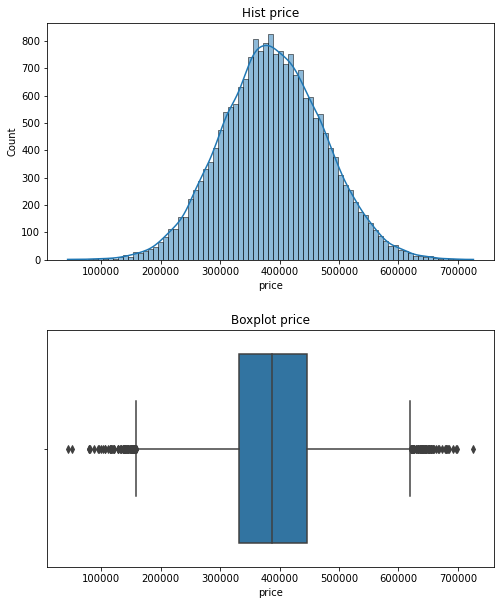


Data IS normal with p-statistic = 0.09689551279019921



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.0000,continuous,4.6682,0.0969,True,nan,389216.0103,387891.5562


In [466]:
explore_data('price', df, 'price', plot_v_target=False)

---------------------------------------------------------------------------
Exploring column: sqft
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: sqft
---------------------------------------------------------------------------
count   20000.0000
mean     2801.1306
std       702.1605
min       232.8931
25%      2326.6143
50%      2803.5581
75%      3278.5229
max      5339.5234
Name: sqft, dtype: float64


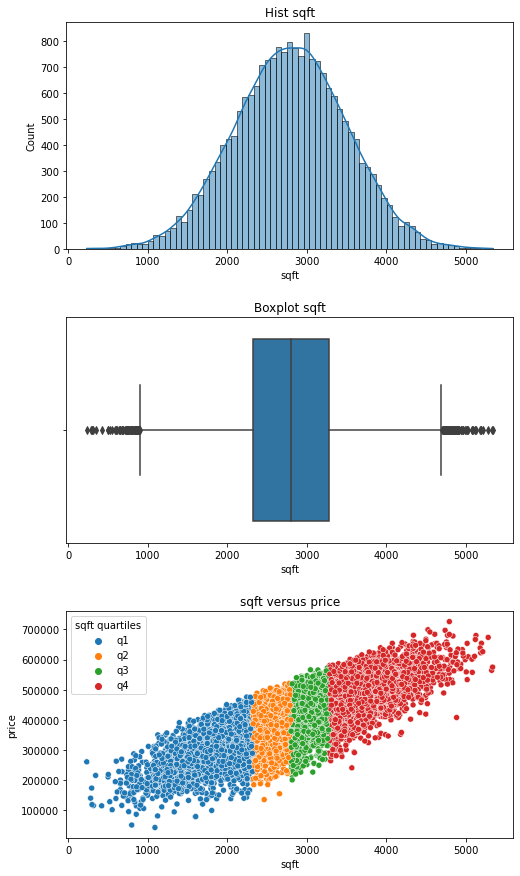


Data IS normal with p-statistic = 0.3749059637869987

---------------------------------------------------------------------------
Exploring column: zip
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: zip
---------------------------------------------------------------------------
30059    417
30069    410
30081    408
30050    401
30044    399
        ... 
30076    159
30079    157
30006    151
30012    150
30000    149
Name: zip, Length: 70, dtype: int64


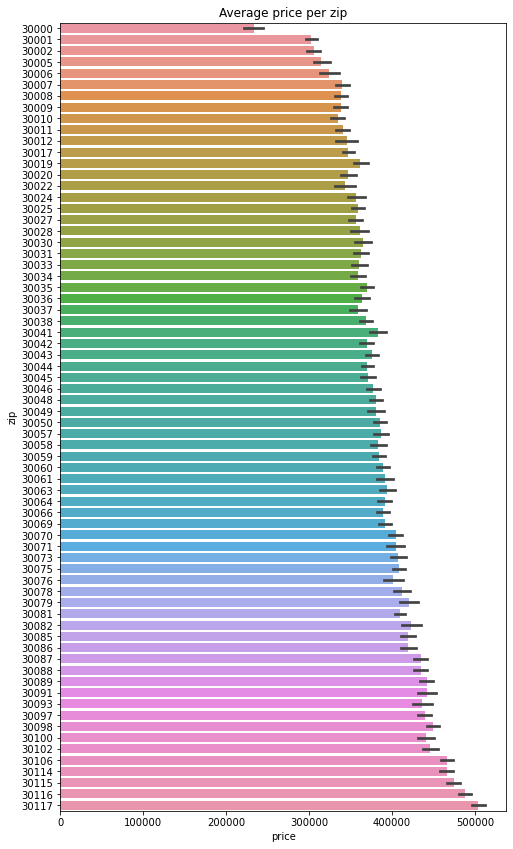

---------------------------------------------------------------------------
Exploring column: condition
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: condition
---------------------------------------------------------------------------
3_average          14000
2_below average     2000
4_above average     2000
5_excellent         1000
1_poor              1000
Name: condition, dtype: int64


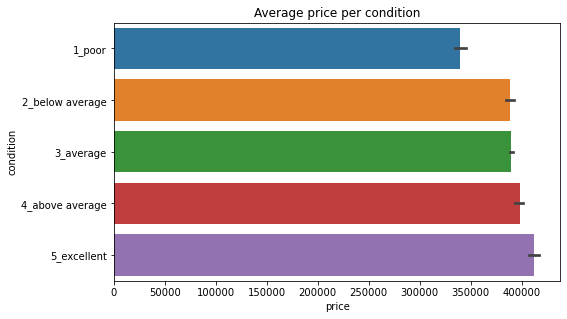

---------------------------------------------------------------------------
Exploring column: dotw
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: dotw
---------------------------------------------------------------------------
Sunday       5373
Wednesday    3371
Monday       2975
Tuesday      2674
Friday       1869
Thursday     1869
Saturday     1869
Name: dotw, dtype: int64


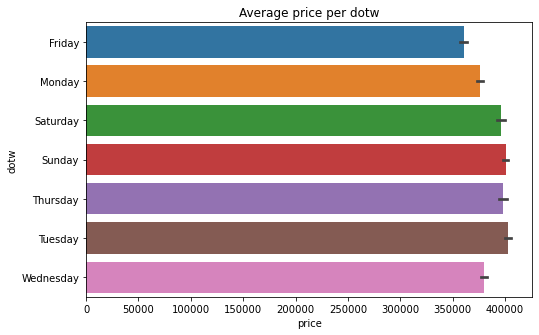

,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,sqft,0.8198,continuous,1.9622,0.3749,True,nan,2801.1306,2803.5581


In [467]:
ind_vars = ['sqft','zip','condition','dotw']

explore_data(ind_vars, df, 'price')

## Summary of Experimental Data
Before we proceed, let's summarize the state of our experimental data:

### Non-Categorical Variables
- We used a baseline price of \\$100,000, so our y-intercept should be 100k.
- We have one continuous independent variable, sq ft, which should have a coefficient of \\$100 per sq ft.

We have three categorical variables: zip, condition, and a confounding variable to add some noise, day of the week (dotw).

### Zip code
- Zip has 70 categories, so a fair amount. 
- Houses were assigned to zip codes randomly, and in fairly even but not totally evenly sized chunks.
- The zip that comes first alphabetically--and will thus be dropped according to convention--is 30000. We have engineered this group to be the smallest (only 149 houses), and with a multiplier (coefficient) on the lower end, so far from the average.

### Condition
- Condition has only 5 categories, so much fewer.
- We purposefully assigned the majority of houses to a condition of *3_average*, and assigned that group a multiplier of 0. 
- Condition scores of 1, 2, 4, and 5 were assigned to fewer houses. The first category, *1_poor* will have a multiplier below average and also much fewer houses than average.

### Day of the Week
- We can model both with dotw and without it to see if the category we drop affects the model to a different degree depending on how much of the variability in target the included variables can explain. 
- Dotw was was assigned randomly, and we're going to just always drop the same category, Friday.


# Modeling

## Preprocessing

In [468]:
def preprocess(df, target, cont_cols, cat_cols=None, cat_drop=None, 
               standardize=True, ttsplit=True, test_prop=0.25, random_state=5):
    """Takes a dataframe and preprocesses it for linear regression modeling.
    
    Returns X_train, X_test, y_train, y_test dataframes after transformation.
    If ttsplit is False, returns X_all, y_all dataframes after transformation.
    
    First, if instructed, does a train-test-split.
    
    If provide cat_cols, also performs one-hot-encoding using OneHotEncoder
    on categorical variables. Drops one of each category columns as directed.
    
    Finally, standardizes the independent variables using StandardScaler. 
    If split into train and test, StandardScaler fit_transforms on train and
    uses the same fit parameters to transform test.
    
    This does NOT fill null values or drop outliers. If you wish to do this, 
    it should be done on data that has already been split for training and
    testing.
    
    -----------------------------------
    PARAMETERS
    -----------------------------------
    df: a dataframe including all rows and columns. If it contains columns
    not specified in target, contcols, or catcols, these will be ignored
    in terms of processing steps.
    
    target: string representing column name of the target variable. This will 
    not be transformed, but will be split into training and testing.
    
    cont_cols: list of continuous columns. These will not be OHE.
    
    cat_cols: list of categorical columns. These are the columns that will be
    OHE. These may be string/text values, or may even be numerical.
    Note that if you want to apply OHE, you must provide at least this list
    of cat cols. If you do not provide the cat_cols, no OHE will be performed.
    
    cat_drop: Default is None. Can also be a list of categories to be dropped, 
    where categories are named like column_category, the way OneHotEncoder will
    atomatically name the columns.
    You may also specify 'first' instead of providing a list to have OHE
    automatically drop the first category for you, or you may specify None
    to have no categories be dropped.
    
    standardize: Default is True. If you do not wish to standardize data, 
    specify False. 
    Only X columns will be standardized; y (target) will be returned as-is.
    If performed OHE, the OHE columns will also be standardized.
    
    ttsplit: Default is True. If you do not wish to perform a train test split,
    specify False. In this case all rows of transformed x columns will be
    returned along with y.
    
    test_prop: Default is 0.25. Represents the proportion of rows that should
    be designated for the test data set versus training. Training will be
    assigned 1-test_prop.
    
    random_state: Default is 5. Random seed to use for reproducability.
    -----------------------------------
    """
    
    X_train, X_test, y_train, y_test = None, None, None, None
    
    # Combine continuous and categorical columns into a single x_cols
    x_cols = cont_cols
    if cat_cols is not None:
        x_cols.extend(cat_cols)
    
    # Perform train-test-split, if indicated
    if ttsplit:
        # perform split
        X_train, X_test, y_train, y_test = train_test_split_custom(
                            df=df, 
                            target=target, 
                            x_cols=x_cols,
                            test_prop=test_prop,
                            random_state=random_state)
    else:
        # if didn't specify to do train-test-split, compile full dfs based
        # on specified columns
        X_train = df[x_cols].copy()
        y_train = df[target].copy()
    
    # perform One Hot encoding
    if cat_cols is not None:
        
        def process_ohe(df, cat_cols, cat_drop):
            # get OHE version
            df_ohe = ohe_custom(df[cat_cols], cat_drop=cat_drop)
            # drop old columns from original df
            df.drop(columns=cat_cols, inplace=True)
            df.reset_index(drop=True, inplace=True)
            # concat non-cat columns from original df with ohe columns
            df = pd.concat([df, df_ohe], axis=1, copy=False)
            return df
        
        X_train = process_ohe(X_train, cat_cols, cat_drop)
        
        if X_test is not None:
            X_test = process_ohe(X_test, cat_cols, cat_drop)
            
    # perform standardization, if indicated
    if standardize:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                               columns=X_train.columns)
        
        if X_test is not None:
            # we're transforming test using the same fit parameters from train
            X_test = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns)
        
    # return final dfs
    if X_test is not None:
        return X_train, X_test, y_train, y_test
    else:
        return X_train, y_train
    

In [469]:
def train_test_split_custom(df, target, x_cols, 
                            test_prop=0.25, random_state=5):
    
    X_train, X_test, y_train, y_test = train_test_split(df[x_cols], 
                                df[target], test_size=test_prop,
                                random_state=random_state)
    
    #print(f"Training set:\n X length: {len(X_train)} Y length: {len(y_train)}")
    #print(f"Testing set:\n X length: {len(X_test)} Y length: {len(y_test)}")
    
    return X_train, X_test, y_train, y_test

In [470]:
def ohe_custom(df, cat_drop=None):
    
    if cat_drop == 'first' or cat_drop == None:
        drop = cat_drop
    else:
        drop = None
        
    ohe = OneHotEncoder(drop=drop)
    ohe_arr = ohe.fit_transform(df).todense()

    cols = ohe.get_feature_names(df.columns)
    df_ohe = pd.DataFrame(ohe_arr, columns=cols)
    
    if type(cat_drop) == list:
        df_ohe.drop(columns=cat_drop, inplace=True)
    
    return df_ohe

## Map model parameters I want to test

I'm going to run 12 different versions of a model with slightly different parameters for the data.

I'll vary:
- Dropping no categorical variables, dropping the first, and dropping the average. My hypothesis is that dropping different categories won't impact model accuracy or performance, but will affect the interpretability of the coefficients.
- Keeping in the 'day of the week' variable to naturally allow the model to predict more variation, versus excluding dotw and having it act as a confounding variable. This will help me determine if changing how I drop OHE categories impacts model performance differently depending on how much variability my available predictors can explain.
- Standardizing the data or not. 

In [471]:
# these are the different model parameters I'll loop through
test_models = [{'id': 1, 'keep_dotw': True, 'cat_drop': None, 'stand': True},
               {'id': 2, 'keep_dotw': True, 'cat_drop': 'first', 'stand': True},
               {'id': 3, 'keep_dotw': True, 'cat_drop': 'avg', 'stand': True},
               {'id': 4, 'keep_dotw': True, 'cat_drop': None, 'stand': False},
               {'id': 5, 'keep_dotw': True, 'cat_drop': 'first', 'stand': False},
               {'id': 6, 'keep_dotw': True, 'cat_drop': 'avg', 'stand': False},
               {'id': 7, 'keep_dotw': False, 'cat_drop': None, 'stand': True},
               {'id': 8, 'keep_dotw': False, 'cat_drop': 'first', 'stand': True},
               {'id': 9, 'keep_dotw': False, 'cat_drop': 'avg', 'stand': True},
               {'id': 10, 'keep_dotw': False, 'cat_drop': None, 'stand': False},
               {'id': 11, 'keep_dotw': False, 'cat_drop': 'first', 'stand': False},
               {'id': 12, 'keep_dotw': False, 'cat_drop': 'avg', 'stand': False}]


## Iterate Models and Save Results

In [472]:
def rss(y_actuals, y_preds):
    """Calculates the Residual Sum of Squares (RSS) a.k.a. Sum of Squared
    Residuals (SSR) a.k.a Squared Sum of Errors (SSE) between predicted and
    actual target values.
    """
    return np.sum((y_actuals - y_preds )**2)

In [492]:
# I'll save the results of each model test to separate lists for the coefficients
# and the statistics (r-squared and RMSE for train and test)
results_coefs = []
results_stats = []

avg_cats = ['condition_3_average', 'zip_30066', 'dotw_Saturday']
all_cat_cols = ['zip', 'condition', 'dotw']

# loop through models with different parameters, and get results  
for model in test_models:
    
    # determine category behavior based on model parameters
    if model['keep_dotw']:
        cat_drop = avg_cats if model['cat_drop'] == 'avg' else model['cat_drop']
        cat_cols = all_cat_cols
    else:
        cat_drop = avg_cats[:-1] if model['cat_drop'] == 'avg' else model['cat_drop']
        cat_cols = all_cat_cols[:-1]
    
    # preprocess according to model parameters
    X_train, X_test, y_train, y_test = preprocess(
        df, 'price', ['sqft'], cat_cols=cat_cols, cat_drop=cat_drop, 
        standardize=model['stand'])
    
    # fit linear regression to preprocessed training data
    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X_train, y_train)
    y_pred_train = linreg.predict(X_train)
    y_pred_test = linreg.predict(X_test)
    
    # set up to prepare to record results
    coef_dict = {'model_id': model['id']}
    acc_dict = {'model_id': model['id']}
    x_cols = X_train.columns
    
    # record coefficients and y-intercept
    coef_dict['y-intercept'] = linreg.intercept_
    for i, coef in enumerate(linreg.coef_):
        coef_dict[x_cols[i]] = coef
    
    # append coefficient results for this model to overall list
    results_coefs.append(coef_dict)
    
    # get statistics for model performance
    acc_dict['R-sq Train'] = linreg.score(X_train, y_train)
    acc_dict['R-sq Test'] = linreg.score(X_test, y_test)
    acc_dict['RMSE Train'] = metrics.mean_squared_error(y_true=y_train, 
                            y_pred=y_pred_train, squared=False)
    acc_dict['RMSE Test'] = metrics.mean_squared_error(y_true=y_test, 
                            y_pred=y_pred_test, squared=False)
    acc_dict['RSS Train'] = rss(y_train, y_pred_train)
    acc_dict['RSS Test'] = rss(y_test, y_pred_test)
    
    # append statistic results for this model to overall list
    results_stats.append(acc_dict)

# turn results lists into dataframes
df_coefs = pd.DataFrame(results_coefs)
df_stats = pd.DataFrame(results_stats)

# display results dfs
display(df_coefs)
display(df_stats)

,model_id,y-intercept,sqft,zip_30000,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,...,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Friday,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,1,389405.0469,70133.6266,4826885541855416.0000,7037749836267671.0000,6475703566027100.0000,5749730690782562.0000,4805254983424009.0000,7595887973142841.0000,7391884330184743.0000,...,13741410668053096.0000,8973893690423098.0000,6559017031041776.0000,-4044912852283100.5000,-4960233140794557.0000,-4038399272874222.0000,-6183115561858508.0000,-4066941353177388.0000,-4729327839489217.0000,-5208561831216014.0000
1,2,389407.3484,70133.6647,nan,7514.2978,7875.7854,7905.8812,7202.0323,12617.0876,12819.2516,...,27421.0490,19234.4932,16086.8438,nan,4443.2496,9426.6293,17850.8741,10228.2142,12746.9151,6548.2120
2,3,389407.3484,70133.6647,-13238.5938,-11787.9853,-9884.9857,-7863.7799,-5977.2358,-8215.9888,-7454.3085,...,nan,1327.0466,2998.2948,-9441.8336,-7135.1694,nan,3417.9430,734.9606,1707.4865,-5609.8680
3,4,97063.7765,100.0037,-148140.9216,-88007.1309,-79644.0217,-70700.6650,-63729.2244,-54590.7531,-50468.5993,...,10358.5653,14800.5399,24089.6988,-25038.1672,-12562.5319,7471.4028,15170.1756,9988.2694,12499.7113,-7528.8601
4,5,-125697.6889,100.0037,nan,60133.7908,68496.9000,77440.2566,84411.6972,93550.1685,97672.3223,...,59940.9419,64382.9165,73672.0754,nan,12475.6353,32509.5700,40208.3428,35026.4366,37537.8785,17509.3071
5,6,121220.9432,100.0037,-154468.1203,-94334.3295,-85971.2203,-77027.8636,-70056.4231,-60917.9518,-56795.7979,...,nan,4441.9746,13731.1335,-32509.5700,-20033.9346,nan,7698.7728,2516.8667,5028.3086,-15000.2628
6,7,389409.4583,70392.2300,1287532392232381.5000,1877262430209843.2500,1727341166779981.2500,1533693817023451.5000,1281762617006743.7500,2026141230909490.0000,1971724921228261.0000,...,-29234211782014608.0000,-19091541253836888.0000,-13954003529853510.0000,nan,nan,nan,nan,nan,nan,nan
7,8,389407.3484,70392.8937,nan,7301.2596,7850.9798,8003.1961,7244.0110,12572.5618,12802.3996,...,24972.3020,18105.7518,15476.1186,nan,nan,nan,nan,nan,nan,nan
8,9,389407.3484,70392.8937,-13172.9124,-11905.2579,-9821.6736,-7688.2260,-5869.8701,-8157.1542,-7370.5761,...,nan,1797.4710,3556.3995,nan,nan,nan,nan,nan,nan,nan
9,10,1144218751980.5503,100.3733,-697037890560.8678,-697037832131.9331,-697037822279.7045,-697037812167.3844,-697037805657.1581,-697037797340.8394,-697037793016.9424,...,-447180901349.1108,-447180895332.5010,-447180885062.0525,nan,nan,nan,nan,nan,nan,nan


,model_id,R-sq Train,R-sq Test,RMSE Train,RMSE Test,RSS Train,RSS Test
0,1,0.9968,0.9969,4825.8991,4861.3256,349339531770.8617,118162431706.1111
1,2,0.9968,0.9969,4825.6893,4861.0910,349309155602.9023,118151030008.3358
2,3,0.9968,0.9969,4825.6893,4861.0910,349309155602.9022,118151030008.3352
3,4,0.9968,0.9969,4825.6893,4861.0910,349309155602.9022,118151030008.3307
4,5,0.9968,0.9969,4825.6893,4861.0910,349309155602.9023,118151030008.3512
5,6,0.9968,0.9969,4825.6893,4861.0910,349309155602.9022,118151030008.3473
6,7,0.9720,0.9727,14298.2511,14365.1701,3066599781550.6470,1031790553536.0176
7,8,0.9721,0.9727,14289.6068,14360.4237,3062892922873.3242,1031108848099.2756
8,9,0.9721,0.9727,14289.6068,14360.4237,3062892922873.3237,1031108848099.2753
9,10,0.9721,0.9727,14289.6068,14360.4237,3062892922774.0840,1031108850146.8215


# Accuracy Interpretation
In terms of accuracy, I see that the first 6 models are pretty similar, and the last 6 models are pretty similar.

The first 6 models are more accurate than the last 6.

Models 1-6 included all the independent variables I created, and models 7-12 did not include 'day of the week' so that it acted as a confounding variable. It makes sense that the last 6 models would have larger errors and be slightly less accurate, since they aren't using all the variables that affect price.

There is also a SLIGHT variation between model 1 and 2-5, and model 6 and 7-12. These represent the models for which I standardized the data, and didn't drop any of the categorical variables during OHE. I really don't see any difference between the versions of the models where I dropped the first, or average category.

I conclude that changing the category which is dropped from modeling does not affect either the amount of variability that the model explains, or the accuracy of the model's predictions.

# Coefficient Interpretation
The coefficients change quite a lot for each model. I can see some patterns in the result dataframe, but I should probably do direct comparisons to the expected coefficients and make some visualizations to help me interpret what's happening.

I will want to compare models 1, 2, 3; models 4, 5, 6; models 7, 8, 9; and models 10, 11, 12. These are the sets where I changed how I dropped categories.

I think what I'd like to do is calculate the average difference of the modeled coefficient from the expected for each group: zip, condition, and dotw.

In [559]:
cat_diffs = []

# loop through models
for i in range(1, 13):
    diffs = {'model_id': i}
    
    # get row from df and transpose it
    coefs = df_coefs.loc[df_coefs['model_id'] == i].transpose()
    coefs.drop(labels=['model_id'], inplace=True)
    coefs.rename(columns={i-1:'model'}, inplace=True)
    
    # concatenate with expected coefs so we can subtract where coefs exist
    coefs = pd.concat([coefs, df_ex_coefs], axis=1)
    
    # calculate the difference between mode coef and expected
    coefs['diff'] = coefs.apply((lambda x: x[1] - x[0]), axis=1)
    coefs['abs_diff'] = coefs.apply((lambda x: abs(x[1] - x[0])), axis=1)
    
    # get average difference per categorical group
    diffs['y-intercept_diff'] = coefs.at['y-intercept','diff']
    diffs['sqft_diff'] = coefs.at['sqft','diff']
    
    for cat in ['zip', 'condition', 'dotw']:
        diffs[cat + '_meandiff'] = coefs.filter(like=cat, axis=0)['diff'].mean()
        diffs[cat + '_meanabsdiff'] = coefs.filter(like=cat, axis=0)['abs_diff'].mean()
    
    cat_diffs.append(diffs)
    
df_diffs = pd.DataFrame(cat_diffs)
df_diffs


,model_id,y-intercept_diff,sqft_diff,zip_meandiff,zip_meanabsdiff,condition_meandiff,condition_meanabsdiff,dotw_meandiff,dotw_meanabsdiff
0,1,-289405.0469,-70033.6266,-6618799700260097.0000,6618799700260097.0000,-8958181509176136.0000,8958181509176136.0000,4747355978814001.0000,4747355978814001.0000
1,2,-289407.3484,-70033.6647,-10639.9251,32610.1108,-17535.3610,17535.3610,-5624.0157,7323.4295
2,3,-289407.3484,-70033.6647,5543.8362,31141.0472,-10815.2449,18652.5741,1887.7468,7195.4125
3,4,2936.2235,-0.0037,5044.9762,5044.9762,-11000.0000,11000.0000,714.2857,3620.0502
4,5,225697.6889,-0.0037,-143097.5620,143097.5620,-60102.9708,60102.9708,-24627.8617,24627.8617
5,6,-21220.9432,-0.0037,11376.6599,11376.6599,-801.7934,1715.2394,7883.3032,8782.8942
6,7,-289409.4583,-70292.2300,-1765510894743630.5000,1765510894743630.5000,19058114319328844.0000,19058114319328844.0000,nan,nan
7,8,-289407.3484,-70292.8937,-10532.4747,32582.8604,-16431.7627,16431.7627,nan,nan
8,9,-289407.3484,-70292.8937,5559.9166,31156.8343,-11707.1039,19030.1686,nan,nan
9,10,-1144218651980.5503,-0.3733,697037748360.2173,697037748360.2173,447180897891.9850,447180897891.9850,nan,nan


In [ ]:
# these are the different model parameters I'll loop through
test_models = [{'id': 1, 'keep_dotw': True, 'cat_drop': None, 'stand': True},
               {'id': 2, 'keep_dotw': True, 'cat_drop': 'first', 'stand': True},
               {'id': 3, 'keep_dotw': True, 'cat_drop': 'avg', 'stand': True},
               {'id': 4, 'keep_dotw': True, 'cat_drop': None, 'stand': False},
               {'id': 5, 'keep_dotw': True, 'cat_drop': 'first', 'stand': False},
               {'id': 6, 'keep_dotw': True, 'cat_drop': 'avg', 'stand': False},
               {'id': 7, 'keep_dotw': False, 'cat_drop': None, 'stand': True},
               {'id': 8, 'keep_dotw': False, 'cat_drop': 'first', 'stand': True},
               {'id': 9, 'keep_dotw': False, 'cat_drop': 'avg', 'stand': True},
               {'id': 10, 'keep_dotw': False, 'cat_drop': None, 'stand': False},
               {'id': 11, 'keep_dotw': False, 'cat_drop': 'first', 'stand': False},
               {'id': 12, 'keep_dotw': False, 'cat_drop': 'avg', 'stand': False}]